In [8]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import itertools
import torch.optim as optim

In [9]:
def rotation_matrix(n, theta):
    """
    Compute the Rodrigues rotation matrix for a given axis n and angle theta.

    Parameters:
        n (torch.Tensor): Rotation axis (normalized).
        theta (float): Rotation angle in radian.

    Returns:
        - (torch.Tensor) -- 3x3 rotation matrix.
    """
    K = torch.tensor([[0.0, -n[2], n[1]], 
                      [n[2], 0.0, -n[0]], 
                      [-n[1], n[0], 0.0]])
    I = torch.eye(3)
    R = I + torch.sin(theta) * K + (1.0 - torch.cos(theta)) * torch.mm(K, K)
    return R

def cross_product(v1, v2):
    return torch.cross(v1, v2, dim=0)

def magnetic(axis, vec, theta):
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    axis = axis.unsqueeze(0)  # (1, 3)
    vec = vec.unsqueeze(0)    # (1, 3)
    
    rotated_vecs = []
    for i in range(theta.size(0)):
        theta_i = theta[i]
        cos_theta_i = cos_theta[i]
        sin_theta_i = sin_theta[i]
        
        axis_i = axis[0]
        vec_i = vec[0]
        
        rotated_vec = vec_i * cos_theta_i + cross_product(axis_i, vec_i) * sin_theta_i + axis_i * (torch.matmul(axis_i.unsqueeze(1).T, vec_i.unsqueeze(1)).squeeze() * (1 - cos_theta_i))
        rotated_vecs.append(rotated_vec)
    
    return torch.stack(rotated_vecs)

def model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2):
    rad = torch.pi / 180.0  # Conversion factor from degrees to radians
    nx = torch.cos(p1 * rad) * torch.sin(t1 * rad)
    ny = torch.sin(p1 * rad) * torch.sin(t1 * rad)
    nz = torch.cos(t1 * rad)
    sx = torch.cos(p2 * rad) * torch.sin(t2 * rad)
    sy = torch.sin(p2 * rad) * torch.sin(t2 * rad)
    sz = torch.cos(t2 * rad)
    theta = x * rad

    # Define matrices
    E = torch.eye(3)
    C3 = rotation_matrix(torch.tensor([0.0, 0.0, 1.0]), torch.tensor([2.0 * torch.pi / 3.0])) # for Te2.
    C3i = C3.T # for Te3.
    Rs = [E, C3i, C3]
    
    h = magnetic(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz]), theta)
    ht = magnetic(cross_product(torch.stack([nx, ny, nz]), torch.stack([sx, sy, sz])), torch.stack([sx, sy, sz]), theta)
    k = torch.stack([
    torch.stack([k1, k6, k5]),
    torch.stack([k6, k2, k4]),
    torch.stack([k5, k4, k3])
    ])
    Ks = [torch.einsum('ik,kl,jl->ij', R, k, R) for R in Rs]
    shift1 = [torch.einsum('ij,jk,ik->i', h, K, h) for K in Ks]
    shift2 = [torch.einsum('ij,jk,ik->i', ht, K, ht) for K in Ks]
    return {'shift1': torch.stack(shift1), 'shift2': torch.stack(shift2)}

In [10]:
# 各CSVファイルの読み込み
csv_files1 = ['xy(1) copy.csv', 'xy(2) copy.csv', 'xy(3) copy.csv']
df1 = [pd.read_csv(f) for f in csv_files1]

csv_files2 = ['xy1 copy.csv', 'xy2 copy.csv', 'xy3 copy.csv']
df2 = [pd.read_csv(f) for f in csv_files2]

dfs = [df1, df2]

# データの抽出
x_values = []
y_values = []

for df_group in dfs:
    for i in range(len(df_group)):
        x_values.append(df_group[i]['x'].values)
        y_values.append(df_group[i]['y'].values)

# リストの全てのデータをtorch.tensorに変換
x_tensors = []
y_tensors = []

for x, y in zip(x_values, y_values):
    x_tensors.append(torch.tensor(x, dtype=torch.float32, requires_grad=True))
    y_tensors.append(torch.tensor(y, dtype=torch.float32))

# 結果を個別に代入（必要なら）
x1, x2, x3, x4, x5, x6 = x_tensors
y1, y2, y3, y4, y5, y6 = y_tensors

In [11]:
def loss_fn(y_p, y):
    squared_diffs = (y_p - y)**2
    return squared_diffs.mean()

In [12]:
def combined_loss_fn(*args):
    total_loss = 0
    # y_predとy_actualをペアでループしながらlossを計算
    for y_pred, y_actual in zip(args[::2], args[1::2]):
        total_loss += loss_fn(y_pred, y_actual)
    
    return total_loss

In [13]:
# 最適化のためのobjective関数
def objective(trial):
    k1 = torch.tensor(trial.suggest_float('k1', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k2 = torch.tensor(trial.suggest_float('k2', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k3 = torch.tensor(trial.suggest_float('k3', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k4 = torch.tensor(trial.suggest_float('k4', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k5 = torch.tensor(trial.suggest_float('k5', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    k6 = torch.tensor(trial.suggest_float('k6', -10.0, 10.0), dtype=torch.float32, requires_grad=True)
    t1 = torch.tensor(trial.suggest_float('t1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p1 = torch.tensor(trial.suggest_float('p1', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    t2 = torch.tensor(trial.suggest_float('t2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)
    p2 = torch.tensor(trial.suggest_float('p2', 0.0, 90.0), dtype=torch.float32, requires_grad=True)

    # モデルにこれらのパラメータを使用
    outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]
    
    y_p1, y_p2, y_p3 = [outputs[i]['shift1'][i] for i in range(3)]
    y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][i] for i in range(3)]

    loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

    return loss.item()

# 最適化のための変数初期化
best_epoch0_loss = float('inf')
best_params = None

for _ in range(10):
    # Optunaで最適化
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=100)

    # epoch0のLossが最小のパラメータを保持
    if study.best_value < best_epoch0_loss:
        best_epoch0_loss = study.best_value
        best_params = study.best_params

# エポック計算 (各組み合わせごとに計算)
if best_params is not None:
    k1 = torch.nn.Parameter(torch.tensor(best_params['k1']))
    k2 = torch.nn.Parameter(torch.tensor(best_params['k2']))
    k3 = torch.nn.Parameter(torch.tensor(best_params['k3']))
    k4 = torch.nn.Parameter(torch.tensor(best_params['k4']))
    k5 = torch.nn.Parameter(torch.tensor(best_params['k5']))
    k6 = torch.nn.Parameter(torch.tensor(best_params['k6']))
    t1 = torch.nn.Parameter(torch.tensor(best_params['t1']))
    p1 = torch.nn.Parameter(torch.tensor(best_params['p1']))
    t2 = torch.nn.Parameter(torch.tensor(best_params['t2']))
    p2 = torch.nn.Parameter(torch.tensor(best_params['p2']))

    optimizer = optim.Adam([k1, k2, k3, k4, k5, k6, t1, p1, t2, p2], lr=1e-2)

    prev_loss = float('inf')

    # エポックごとのトレーニング
    best_params_during_epoch = None  # エポックごとの最良パラメータ
    best_epoch_loss = float('inf')  # 最良のロスを記録

    for epoch in range(300000):
        optimizer.zero_grad()

        outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

        y_p1, y_p2, y_p3 = [outputs[i]['shift1'][i] for i in range(3)]
        y_p4, y_p5, y_p6 = [outputs[i+3]['shift2'][i] for i in range(3)]

        loss = combined_loss_fn(y_p1, y1, y_p2, y2, y_p3, y3, y_p4, y4, y_p5, y5, y_p6, y6)

        if epoch == 0:
            epoch0_loss = loss.item()
            if epoch0_loss >= 35:
                print(f"Epoch 0 Loss is {epoch0_loss}, which is >= 35. Stopping training.")
                break
        
        # 最良のロスを持つ場合はパラメータを保存
        if loss.item() < best_epoch_loss:
            best_epoch_loss = loss.item()
            best_params_during_epoch = {
                'k1': k1.item(),
                'k2': k2.item(),
                'k3': k3.item(),
                'k4': k4.item(),
                'k5': k5.item(),
                'k6': k6.item(),
                't1': t1.item(),
                'p1': p1.item(),
                't2': t2.item(),
                'p2': p2.item()
            }

        if loss.item() > prev_loss:
            print(f"Loss increased at epoch {epoch}. Stopping training.")
            break

        prev_loss = loss.item()
        loss.backward()
        optimizer.step()

        # パラメータのクランプ
        with torch.no_grad():
            # Clamp the first 6 parameters to be within [-10, 10]
            for param in [k1, k2, k3, k4, k5, k6]:
                param.data = torch.clamp(param.data, -10.0, 10.0)
            
            # Clamp the remaining 4 parameters to be within [0, 90]
            for param in [t1, p1, t2, p2]:
                param.data = torch.clamp(param.data, 0.0, 90.0)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
            # パラメータを表示する
            print(f'Parameters: k1={k1.item()}, k2={k2.item()}, k3={k3.item()}, k4={k4.item()}, k5={k5.item()}, k6={k6.item()}, t1={t1.item()}, p1={p1.item()}, t2={t2.item()}, p2={p2.item()}')
    
    # 最良のパラメータを表示
    if best_params_during_epoch is not None:
        print(f"Best params during epoch training: {best_params_during_epoch}")
        # 最良のパラメータをTensorに変換して使用
        k1, k2, k3, k4, k5, k6, t1, p1, t2, p2 = [torch.tensor(best_params_during_epoch[param], dtype=torch.float32) for param in ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 't1', 'p1', 't2', 'p2']]
    else:
        print("No improvement in loss during epoch training.")

[I 2024-09-27 15:43:51,730] A new study created in memory with name: no-name-2dbea76c-f4ba-43d7-8fc3-1e3bba6845d1
[I 2024-09-27 15:43:51,763] Trial 0 finished with value: 454.2692565917969 and parameters: {'k1': -8.34150183446399, 'k2': -3.281674013723375, 'k3': 5.846872161642626, 'k4': -8.412220231972364, 'k5': -4.2946657193096645, 'k6': 9.01906733001114, 't1': 32.88224963596494, 'p1': 58.35946067629335, 't2': 9.32160922188896, 'p2': 63.89979662440711}. Best is trial 0 with value: 454.2692565917969.
[I 2024-09-27 15:43:51,788] Trial 1 finished with value: 372.25714111328125 and parameters: {'k1': -4.56785585307655, 'k2': 0.8333958418993443, 'k3': 0.9457905564556981, 'k4': -5.356911966490172, 'k5': 8.539984170340915, 'k6': 9.938993485791134, 't1': 42.19844546743398, 'p1': 47.44579773078435, 't2': 58.728320760144854, 'p2': 40.62950796675831}. Best is trial 1 with value: 372.25714111328125.
[I 2024-09-27 15:43:51,812] Trial 2 finished with value: 345.87750244140625 and parameters: {'k1':

Epoch 0, Loss: 26.600690841674805
Parameters: k1=-3.3322548866271973, k2=-2.808881998062134, k3=-1.4729926586151123, k4=8.235210418701172, k5=-2.616072177886963, k6=-4.895747184753418, t1=36.58404541015625, p1=47.160614013671875, t2=85.53382110595703, p2=40.00318908691406
Epoch 100, Loss: 15.801345825195312
Parameters: k1=-4.2641472816467285, k2=-2.3292911052703857, k3=-0.5954350233078003, k4=7.840574741363525, k5=-3.4988629817962646, k6=-4.42439079284668, t1=35.555728912353516, p1=48.142208099365234, t2=86.50507354736328, p2=39.0305290222168
Epoch 200, Loss: 10.505281448364258
Parameters: k1=-4.929544448852539, k2=-2.140425443649292, k3=-0.06550957262516022, k4=8.201374053955078, k5=-4.109787464141846, k6=-4.362664699554443, t1=34.76939392089844, p1=49.05026626586914, t2=87.3748550415039, p2=37.54346466064453
Epoch 300, Loss: 8.10020923614502
Parameters: k1=-5.320696830749512, k2=-2.004326820373535, k3=0.12633638083934784, k4=8.556914329528809, k5=-4.392551422119141, k6=-4.25076293945

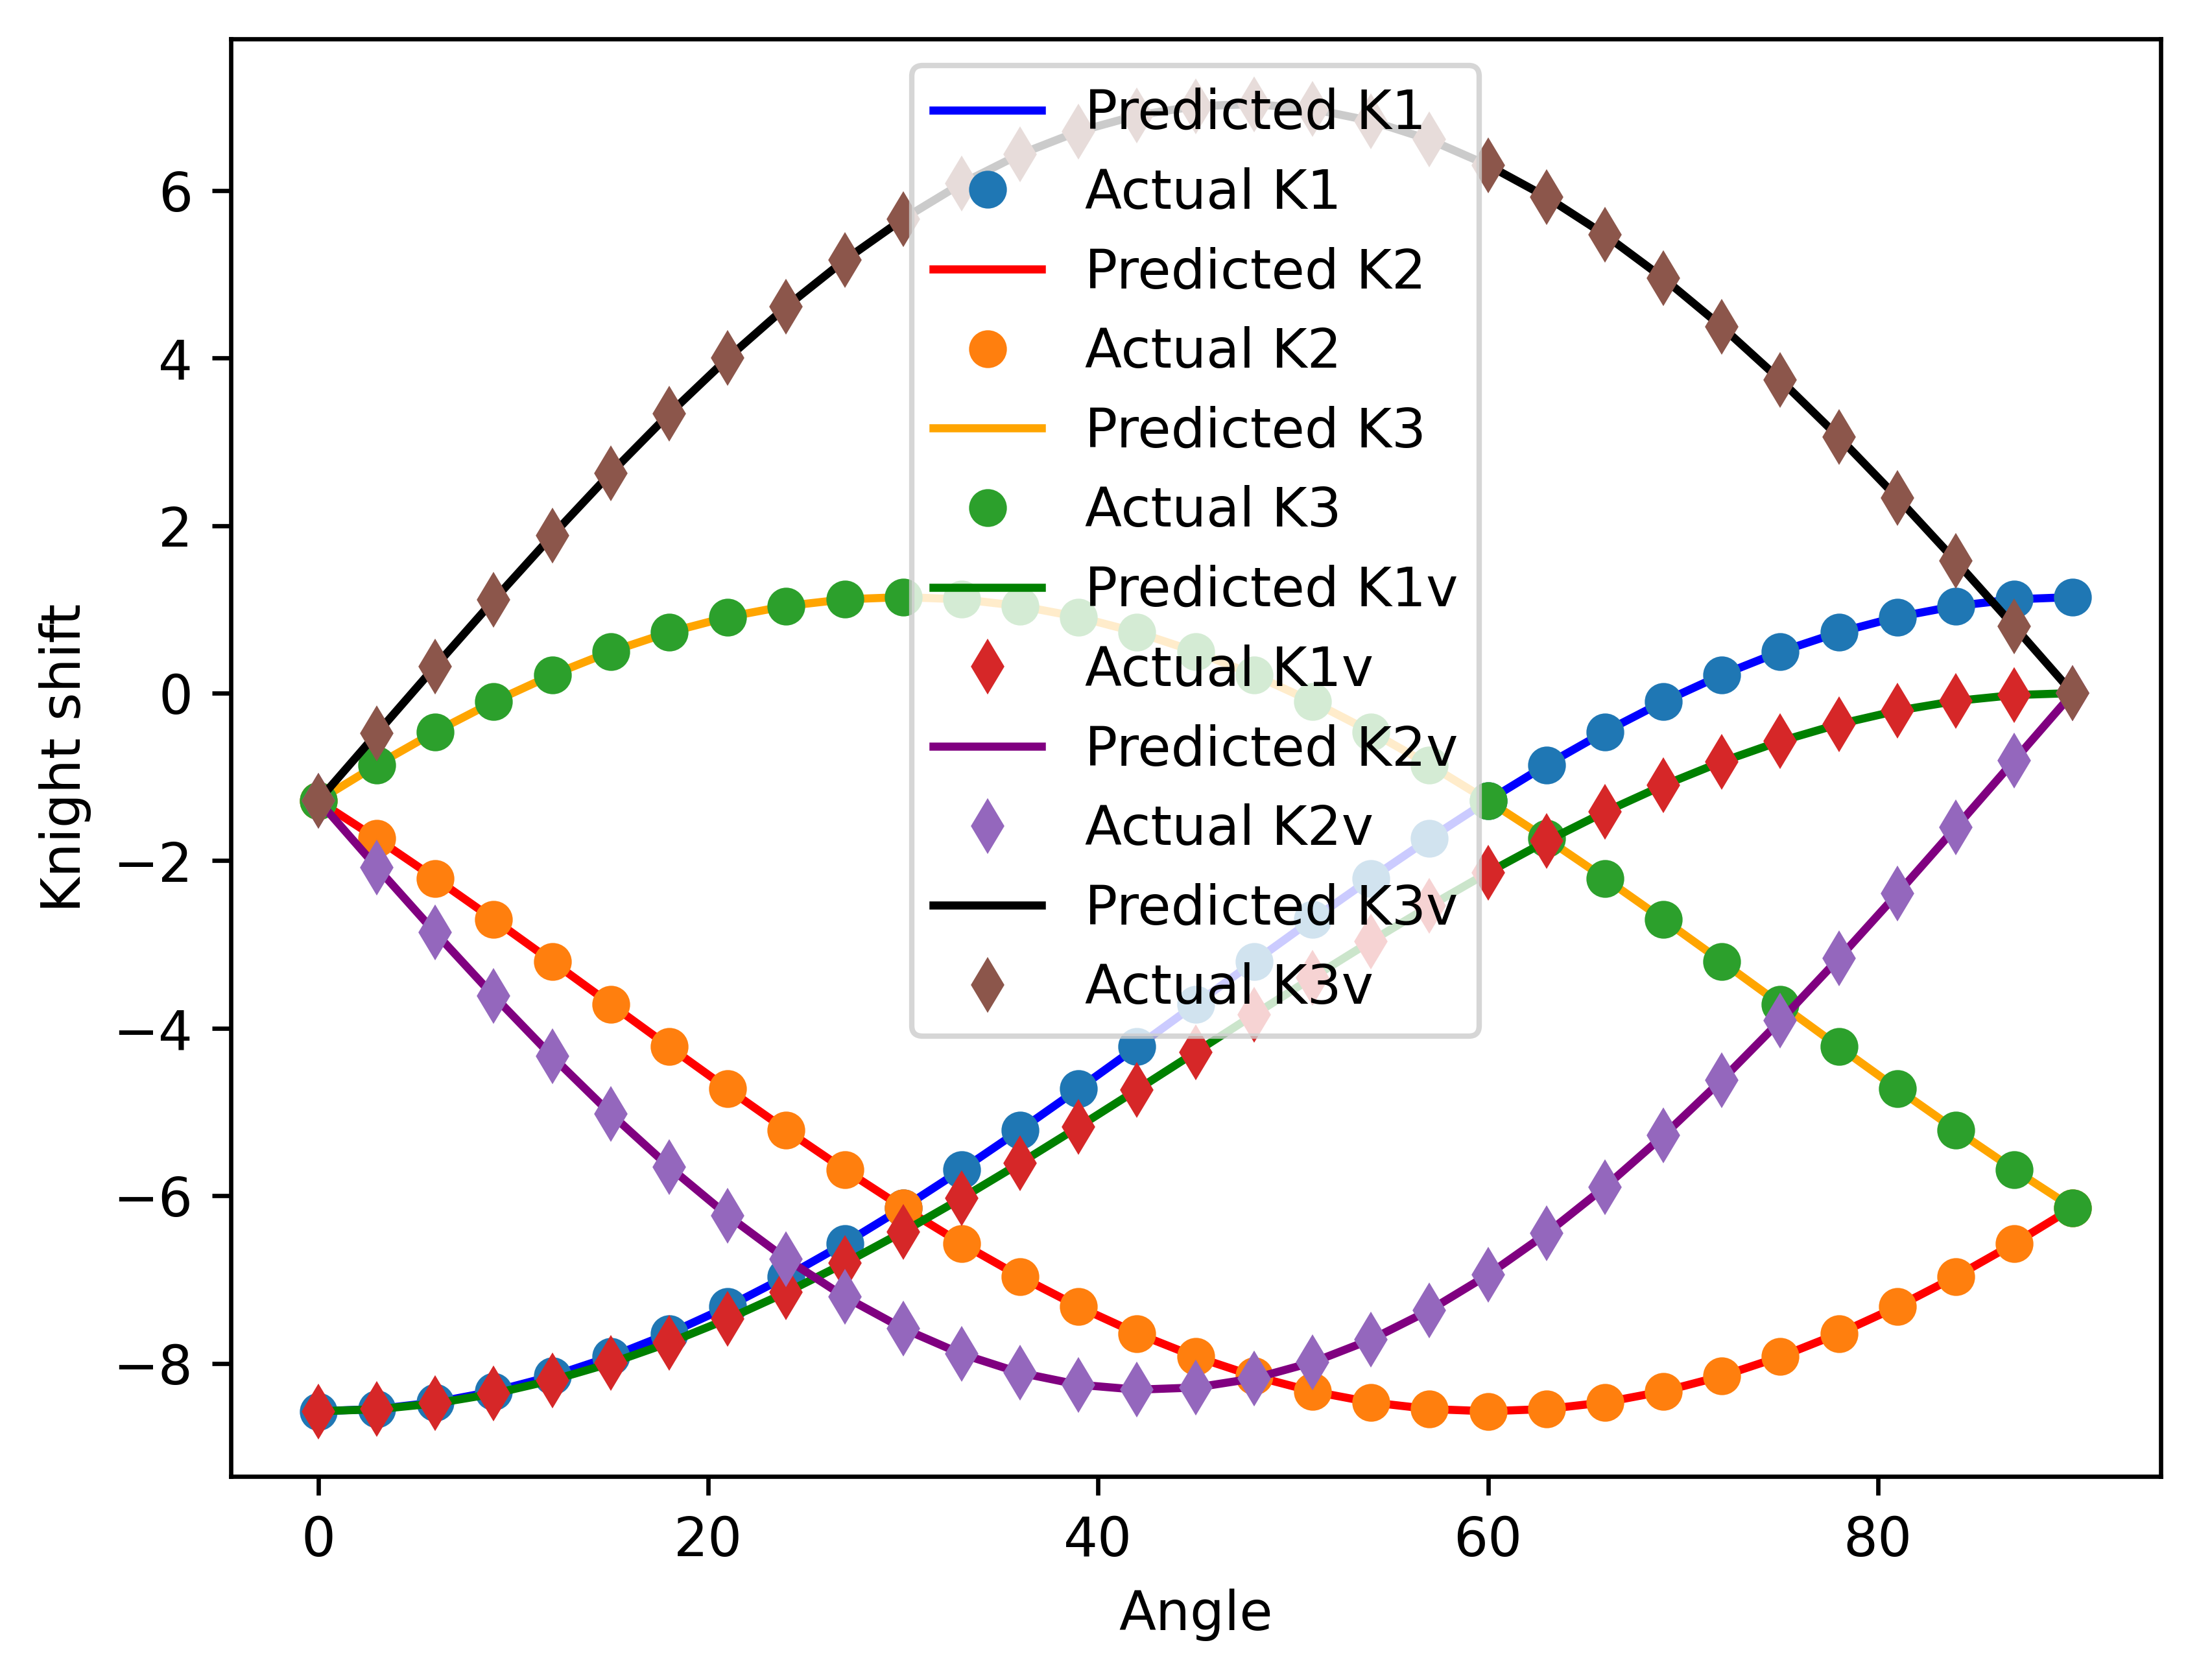

[tensor(-6.3459), tensor(-1.0801), tensor(-2.1988e-07), tensor(7.7530), tensor(-4.2261), tensor(-4.0838), tensor(0.0003), tensor(54.5248), tensor(90.), tensor(28.5947)]


In [14]:
# 最適化後のパラメータを取得し、Tensorに変換
k1 = torch.tensor(best_params_during_epoch['k1'], dtype=torch.float32)
k2 = torch.tensor(best_params_during_epoch['k2'], dtype=torch.float32)
k3 = torch.tensor(best_params_during_epoch['k3'], dtype=torch.float32)
k4 = torch.tensor(best_params_during_epoch['k4'], dtype=torch.float32)
k5 = torch.tensor(best_params_during_epoch['k5'], dtype=torch.float32)
k6 = torch.tensor(best_params_during_epoch['k6'], dtype=torch.float32)
t1 = torch.tensor(best_params_during_epoch['t1'], dtype=torch.float32)
p1 = torch.tensor(best_params_during_epoch['p1'], dtype=torch.float32)
t2 = torch.tensor(best_params_during_epoch['t2'], dtype=torch.float32)
p2 = torch.tensor(best_params_during_epoch['p2'], dtype=torch.float32)

# パラメータリストを作成
params = [k1, k2, k3, k4, k5, k6, t1, p1, t2, p2]

outputs = [model(x, k1, k2, k3, k4, k5, k6, t1, p1, t2, p2) for x in [x1, x2, x3, x4, x5, x6]]

y_p1 = outputs[0]['shift1'][0]
y_p2 = outputs[1]['shift1'][1]
y_p3 = outputs[2]['shift1'][2]
y_p4 = outputs[3]['shift2'][0]
y_p5 = outputs[4]['shift2'][1]
y_p6 = outputs[5]['shift2'][2]

# 結果の可視化
fig = plt.figure(dpi=600)

plt.plot(x1.detach().numpy(), y_p1.detach().numpy(), label="Predicted K1", color = "blue") 
plt.plot(x1.detach().numpy(), y1.numpy(), 'o', label="Actual K1")

plt.plot(x2.detach().numpy(), y_p2.detach().numpy(), label="Predicted K2", color = "red") 
plt.plot(x2.detach().numpy(), y2.numpy(), 'o', label="Actual K2")

plt.plot(x3.detach().numpy(), y_p3.detach().numpy(), label="Predicted K3", color = "orange") 
plt.plot(x3.detach().numpy(), y3.numpy(), 'o', label="Actual K3")

plt.plot(x4.detach().numpy(), y_p4.detach().numpy(), label="Predicted K1v", color = "green") 
plt.plot(x4.detach().numpy(), y4.numpy(), 'd', label="Actual K1v")

plt.plot(x5.detach().numpy(), y_p5.detach().numpy(), label="Predicted K2v", color = "purple") 
plt.plot(x5.detach().numpy(), y5.numpy(), 'd', label="Actual K2v")

plt.plot(x6.detach().numpy(), y_p6.detach().numpy(), label="Predicted K3v", color = "black") 
plt.plot(x6.detach().numpy(), y6.numpy(), 'd', label="Actual K3v")

plt.xlabel("Angle")
plt.ylabel("Knight shift")
plt.legend()
plt.show()

print(params)